<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/Center-for-Computational-Psychiatry/course_nycpw/tutorials/tutorial03_modelfitting.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Fitting models to behavioral data
By [Shawn A. Rhoads, Ph.D.](https://shawnrhoads.github.io/)<br>New York Computational Psychiatry Workshop 2024

This tutorial was inspired by and adapted from Shawn A. Rhoads' [PSYC 347 Course](https://shawnrhoads.github.io/gu-psyc-347/) [[CC BY-SA 4.0 License](https://creativecommons.org/licenses/by-sa/4.0/)] and the [Neuromatch Academy tutorials](https://github.com/NeuromatchAcademy/course-content) [[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)]. 

## Goals of this tutorial

1. Understand the concept of Maximum Likelihood Estimation (**MLE**) and algorithms to maximize the log-likelihood (or minimize the negative log-likelihood)
2. Apply **MLE** to fit a linear regression model to data using a grid search and optimization algorithm
3. Apply **MLE** to fit a reinforcement learning model to data using a grid search and optimization algorithm
4. Understand the concept of Maximum A Posteriori (**MAP**) estimation, hierarchical modeling, and the expectation-maximization (EM) algorithm
5. Apply **MAP Estimation** to fit a linear regression model to data using the EM algorithm
6. Apply **MAP Estimation** to fit a reinforcement learning model to data using the EM algorithm

In [1]:
import numpy as np, pandas as pd, scipy, sys
import matplotlib.pyplot as plt, seaborn as sns

## What is Maximum Likelihood Estimation (MLE)?

Maximum Likelihood Estimation (MLE) is a fundamental method used to estimate the parameters of a model by finding the parameter values that make the observed data most probable. This concept is widely used across various fields to fit models to behavioral and cognitive data.

In simple terms, MLE attempts to answer the question: *Given the data we have observed, what are the parameter values that maximize the probability of observing this data?*

In MLE, we assume a specific form for the probability distribution of the data and adjust the model's parameters until we find the highest likelihood.

<hr width=50%>

### Key Concepts

Given a set of observed data points, MLE aims to find the values of the parameters, denoted by ($\theta$), that maximize the likelihood function:

$$
\mathcal{L}(\theta) = P(\mathcal{D} | \theta)
$$

Here:
- $\mathcal{D}$ represents the observed data.
- $\theta$ represents the set of parameters of the model.

The likelihood function, $\mathcal{L}(\theta)$, expresses how likely the observed data is for different parameter values. MLE finds the parameter value $\theta^*$ that maximizes this likelihood function, which can also be equivalently done by maximizing the log-likelihood, as it is often easier to work with:

$$
\theta^* = \text{argmax}_{\theta} \; \log \mathcal{L}(\theta)
$$

Instead of working directly with the likelihood function, it is often easier to work with the logarithm of the likelihood, called the *log-likelihood*. The log-likelihood is more computationally convenient, especially when dealing with products of probabilities.

MLE requires finding the parameter values that maximize the likelihood or log-likelihood. This is an optimization problem and can be solved using various methods, such as grid search or iterative optimization algorithms.

<hr width=50%>


### Example 1: Linear Regression Model

In the first example, we'll discuss fitting a **multivariate linear regression model** using MLE. I like to start with this example because it's a simple and intuitive model that many people are familiar with.

A multivariate linear regression model extends simple linear regression to multiple predictors. Given a set of observed data points, our goal is to estimate the relationship between the predictors and the outcome variable. Mathematically, the model can be represented as:

$$
Y = X\beta + \epsilon
$$

Here:
- $Y$ is the vector of observed outcome values with shape $(n, 1)$, where $n$ is the number of observations.
- $X$ is the matrix of predictor variables with shape $(n, p)$, where $n$ is the number of observations and $p$ is the number of predictors.
- $\beta$ is the vector of regression coefficients (parameters we wish to estimate) with shape $(p, 1)$.
- $\epsilon$ represents the error term, which is typically assumed to be normally distributed with mean zero and variance $\sigma^2$.

We can also write the expanded form of the model for each observation $i$ as:

$$
 y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \ldots + \beta_p x_{ip} + \epsilon_i
$$

In [2]:
# Let's generate some data based on a simple linear model
np.random.seed(42)
n = 100
x1 = np.random.uniform(0, 10, n)
x2 = np.random.uniform(0, 10, n)
noise = np.random.normal(0, 1, n)
b0 =  2.41 # intercept
b1 =  1.64 # slope 1
b2 = -3.27 # slope 2
y = b0 + b1*x1 + b2*x2 + noise

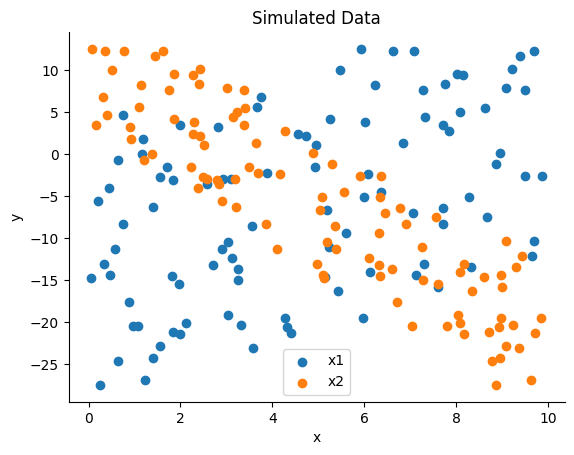

In [3]:
# Let's plot the data
fig, ax = plt.subplots()
ax.scatter(x1, y, label='x1')
ax.scatter(x2, y, label='x2')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower center')
sns.despine()
plt.title('Simulated Data')
plt.show()

<hr width=50%>

Now we can try to estimate the free parameters: `b0`, `b1`, and `b2`. To understand how we estimate the parameters of the model, we need to describe the probability distribution of the errors.

The Gaussian distribution is a common choice for modeling the errors (residuals) in a regression model. This distribution assumes that the errors are normally distributed, meaning that they are symmetrically distributed around zero, and most of the error values are close to zero with fewer extreme values.

The [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF) for the observed outcomes, assuming normally distributed errors, is given by:

$$
P(\mathcal{D} | \beta) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i - X_i \beta)^2}{2\sigma^2} \right)
$$

Let's break this down:
- The term $\frac{1}{\sqrt{2\pi\sigma^2}}$ represents the normalization factor of the Gaussian distribution, which ensures that the total area under the curve is equal to 1.
- The exponential term $\exp\left( -\frac{(y_i - X_i \beta)^2}{2\sigma^2} \right)$ represents how the likelihood of each observation decreases as the difference between the predicted value ($X_i \beta$) and the actual value ($y_i$) increases. This term captures how well the model fits the data.

Where $y_i$ represents the $i$-th observed value and $X_i$ represents the corresponding row of the predictor matrix. The goal of MLE is to find the parameters $\beta$ that maximize this likelihood function, which means finding the values of $\beta$ that make the observed data most probable.

In [4]:
# we can use ipywidgets to create an interactive plot of the probability density function (pdf) of a normal distribution
# install ipywidgets with `!pip install ipywidgets`
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'

@widgets.interact(mu=widgets.FloatSlider(0.0, min=-2.0, max=2.0),
                  sigma=widgets.FloatSlider(1.0, min=0.5, max=2.0))

def plot_normal_dist(mu=0, sigma=1):

    # Generate pdf & samples from normal distribution with mu/sigma
    x = np.linspace(-5, 5, 100)
    y = scipy.stats.norm.pdf(x, mu, sigma)
    samples = scipy.stats.norm.rvs(mu, sigma, size=1000)

    # Plot
    fig, ax = plt.subplots()
    ax.hist(samples, 20, density=True, color='g', histtype='stepfilled', alpha=0.8,
          label='histogram')
    ax.plot(x, y, color='orange', linewidth=3, label='pdf')
    ax.vlines(mu, 0, scipy.stats.norm.pdf(mu, mu, sigma), color='red', linewidth=3, label='$y_i - X_i\hat{\\beta}$')
    ax.vlines([mu-sigma, mu+sigma], 0, 
              scipy.stats.norm.pdf([mu-sigma, mu+sigma], mu, sigma), colors='red',
            color='b', linewidth=3, label='$\sigma$')
    ax.set(xlabel='x', ylabel='probability density', xlim=[-5, 5], ylim=[0, 1.0])
    ax.legend()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='mu', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…


In practice, we often maximize the log-likelihood instead of the likelihood function, as it improves numerical stability (i.e., avoids underflow with very small values), simplifies calculations (i.e., transforms products into sums), allows for easier interpretation (i.e., compresses the range of values for comparison), handles large datasets efficiently through additivity (i.e., sums log-likelihoods across observations), and avoids issues with underflow and overflow in numerical computations (i.e., prevents extreme values in floating-point operations).

Additionally, instead of maximizing the log-likelihood, we can equivalently minimize the negative log-likelihood. This approach is often used because many optimization libraries are designed to minimize functions by default, making it convenient to use negative log-likelihood as our "objective function."

> ***Note*:** Wait - but can't we just use the analytic solution for linear regression? Yes, for linear regression we can easily derive an analytic solution for $\beta$. However, we are starting with a linear model to demonstrate how MLE can be applied to a simple model, as the same approach generalizes to more complex models where an analytic solution is not available.

In [5]:
# let's create a function to calculate the negative log-likelihood - this is often called an objective function
def negll_lm(params, y, x1, x2):
    b0, b1, b2 = params
    y_pred = b0 + b1*x1 + b2*x2
    likelihoods = scipy.stats.norm.logpdf(y, y_pred)
    return -np.sum(likelihoods)

<hr width=50%>

### Algorithms for Maximizing Likelihood

To estimate the model parameters using MLE, we often use optimization algorithms. Some common approaches include:
- **Grid Search**: This involves evaluating the likelihood at a grid of parameter values and selecting the one with the highest value. This is straightforward but computationally expensive for complex models or high-dimensional parameter spaces.
- **Gradient-Based Optimization**: Algorithms like **BFGS** are commonly used to find the parameters that maximize the likelihood. These methods iteratively adjust the parameters based on the gradient of the likelihood function, converging to the optimal values. In Python, the `scipy.optimize.minimize` function is often used for this purpose, with **BFGS** being the default method for unconstrained problems. This function provides a flexible way to optimize the negative log-likelihood function, allowing us to effectively maximize the likelihood of the observed data given the model parameters.

In the next sections, we will explore how to apply MLE to fit different models, starting with a simple linear regression model and then moving on to a reinforcement learning model. We will use both grid search and gradient-based optimization approaches to illustrate the versatility of MLE.

In [6]:
# let's perform a grid search to find the optimal parameters
b0_grid = np.linspace(-10, 10, 50)
b1_grid = np.linspace(-10, 10, 50)
b2_grid = np.linspace(-10, 10, 50)
nll = np.zeros((50, 50, 50))
for i in range(50):
    for j in range(50):
        for k in range(50):
            nll[i, j, k] = negll_lm([b0_grid[i], b1_grid[j], b2_grid[k]], y, x1, x2)

# let's find the optimal parameters
i, j, k = np.unravel_index(nll.argmin(), nll.shape)
b0_opt = b0_grid[i]
b1_opt = b1_grid[j]
b2_opt = b2_grid[k]

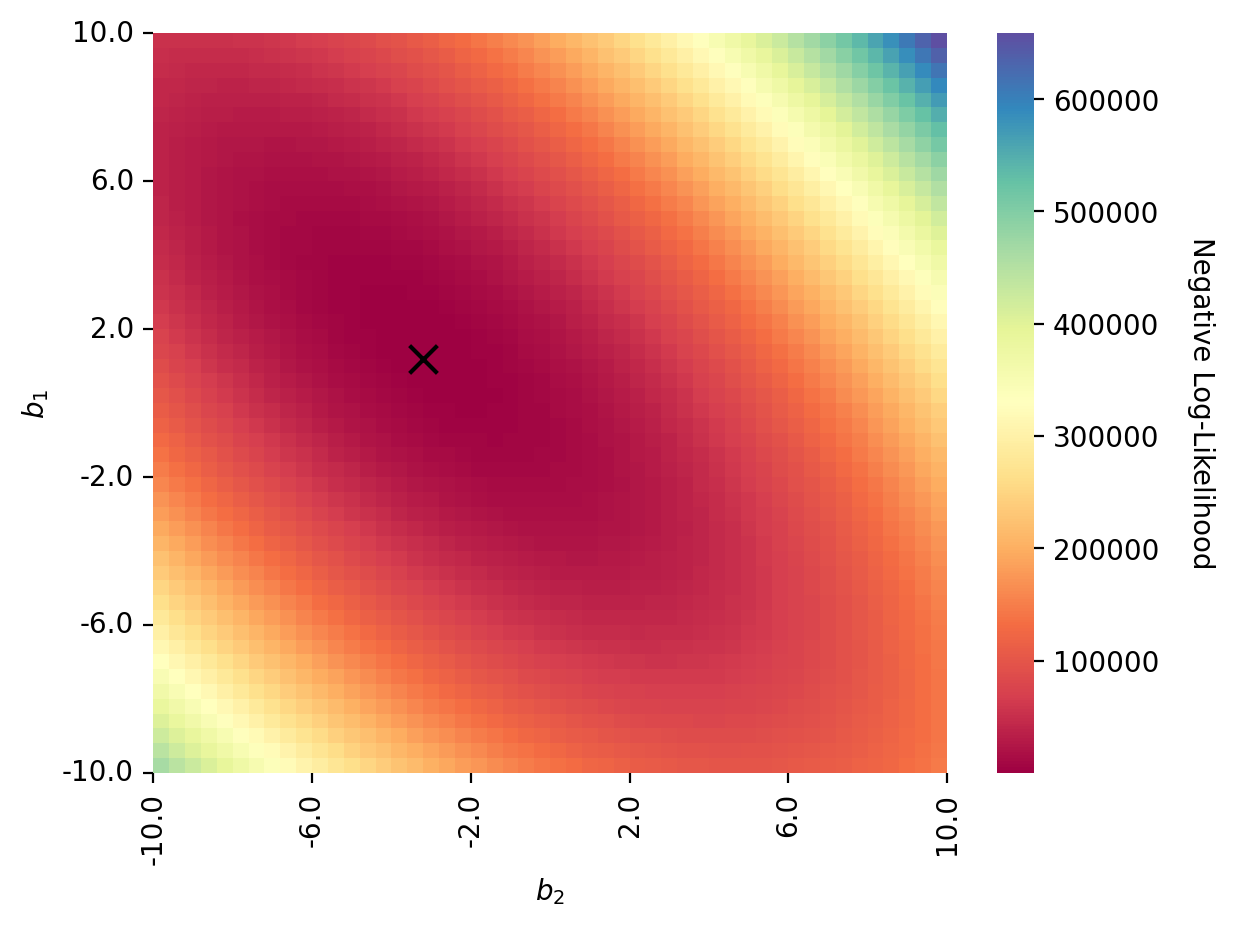

In [7]:
# let's plot the negative log-likelihood as a heatmap
fig, ax = plt.subplots()
sns.heatmap(nll[i, :, :], ax=ax, cmap='Spectral')

# relabel the ticks
ax.set_xlabel(r'$b_2$')
ax.set_xticks(np.linspace(0, 50, 6))
ax.set_xticklabels(np.linspace(-10, 10, 6))

ax.set_ylabel(r'$b_1$')
ax.set_yticks(np.linspace(0 ,50, 6))
ax.set_yticklabels(np.linspace(-10, 10, 6))
ax.invert_yaxis()

# mark the optimal parameters
ax.scatter(k, j, color='black', marker='x', s=100)

ax.collections[0].colorbar.set_label('Negative Log-Likelihood', rotation=270, labelpad=20)

plt.show()

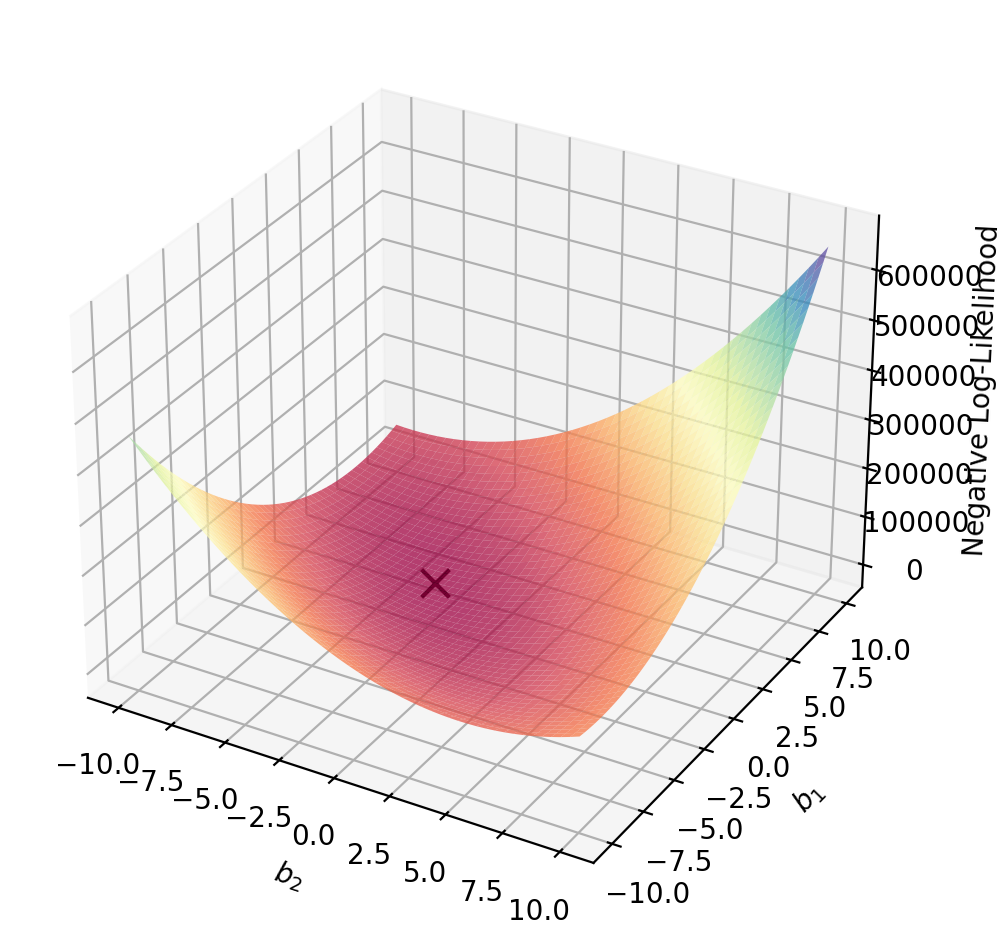

In [8]:
# plot a mesh grid of the negative log-likelihood
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(b1_grid, b2_grid)
ax.plot_surface(X, Y, nll[i, :, :], cmap='Spectral', alpha=0.75)
ax.set_xlabel(r'$b_2$')
ax.set_ylabel(r'$b_1$')
ax.set_zlabel('Negative Log-Likelihood')

# mark the optimal parameters
ax.scatter(b2_opt, b1_opt, nll[i, j, k], color='black', marker='x', s=100)

plt.tight_layout()
plt.show()

In [9]:
# let's print the estimated parameters from the grid search
print(f'Parameter | Actual | Estimated')
print(f'b0        |  {b0:.2f}  |  {b0_opt:.2f}')
print(f'b1        |  {b1:.2f}  |  {b1_opt:.2f}')
print(f'b2        | {b2:.2f}  | {b2_opt:.2f}')

Parameter | Actual | Estimated
b0        |  2.41  |  2.65
b1        |  1.64  |  1.43
b2        | -3.27  | -3.06


In [10]:
# we can use scipy to minimize the negative log-likelihood
initial_guess = [0, 0, 0]
result = scipy.optimize.minimize(negll_lm,
                                 initial_guess, 
                                 args=(y, x1, x2))
b0_hat, b1_hat, b2_hat = result.x

In [11]:
# let's print the estimated parameters from the optimization
print(f'Parameter | Actual | Estimated')
print(f'b0        |  {b0:.2f}  |  {b0_hat:.2f}')
print(f'b1        |  {b1:.2f}  |  {b1_hat:.2f}')
print(f'b2        | {b2:.2f}  | {b2_hat:.2f}')

Parameter | Actual | Estimated
b0        |  2.41  |  2.32
b1        |  1.64  |  1.61
b2        | -3.27  | -3.20


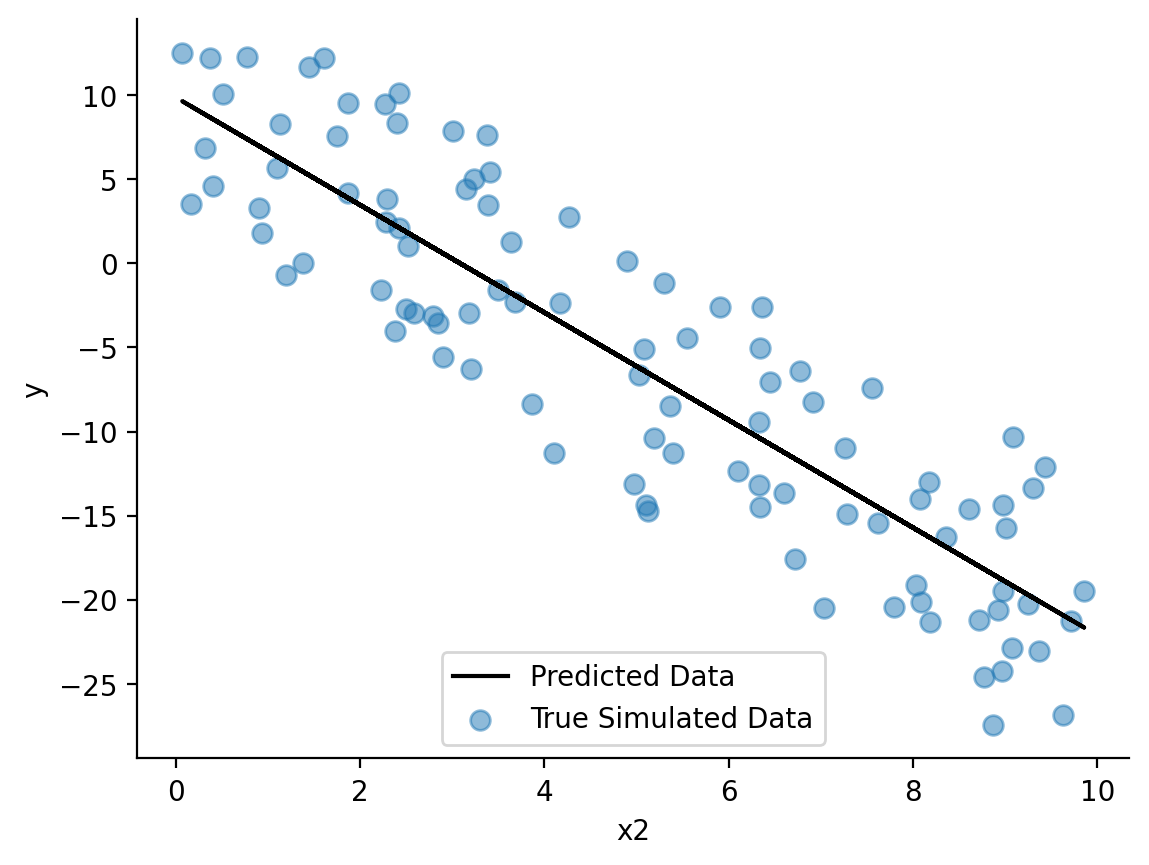

In [12]:
# we can also plot y as a function of x2 (line) with the simulated data points (scatter)
fig, ax = plt.subplots()
y_hat = b0_hat + b1_hat*np.mean(x1) + b2_hat*x2

# plot fitted line
ax.plot(x2, y_hat, label='Predicted Data', color='black')
ax.scatter(x2, y, label='True Simulated Data', alpha=0.5, s=50)
ax.set_xlabel('x2')
ax.set_ylabel('y')
ax.legend(loc='lower center')
sns.despine()
plt.show()

Now, we have estimated the parameters of a linear regression model using both a brute force grid search and the `scipy.optimize.minimize` function. Notice that the estimated parameters from both methods did not exactly match the actual parameters used to generate the data. This discrepancy can be attributed to noise in the data and the limitations of the optimization methods. (Also remember that all models just approximate the true observed data, so we should never expect the estimated parameters to perfectly match the true parameters.)

Additionally, the optimization performed by `scipy` generally did a better job compared to the brute force grid search. This is because `scipy.optimize.minimize` uses more sophisticated algorithms like **BFGS** that can efficiently navigate the parameter space by leveraging gradient information, whereas grid search exhaustively evaluates a fixed grid of values, which is computationally expensive and less precise.

<hr width=50%>

### Example 2: Temporal Difference (TD) Learning Model

Now let's use **MLE** to fit a model to choice behavior. Recall the **Temporal Difference (TD) Learning Model** from yesterday. TD Learning is a core concept in reinforcement learning that involves estimating the value of different states to predict long-term rewards. By observing experiences, we iteratively update our value estimates for the states.

TD-Learning can be written as follows:
$$
Q_{t+1}(S_t, A_t) = Q_t(S_t, A_t) + \alpha \left[R_{t+1} + \gamma \max\limits_{a} Q_t(S_{t+1}, a) - Q_t(S_t, A_t)\right]
$$

Unpacking the terms:
- $Q_t(S_t, A_t)$: value of taking action $A_t$ in state $S_t$ at time $t$
- $0 < \alpha < 1$: learning rate, which controls how "quickly" the value is updated
- $R_{t+1}$: immediate reward received after taking action $A_t$ in state $S_t$
- $\gamma$: discount factor, which determines the importance of future rewards
- $\max\limits_{a} Q_t(S_{t+1}, a)$: the maximum estimated value of the next state $S_{t+1}$ over all possible actions

The action selection is often guided by the softmax function, which converts the estimated values of available actions into a probability distribution over actions. The probability of selecting action $a$ given the estimated value $V(S_t, a)$ is given by the softmax function:

$$
P(a) = \frac{e^{\beta Q(S_t, a)}}{\sum_{a'} e^{\beta Q(S_t, a')}}
$$

Here, $\beta$ is the inverse temperature parameter that controls the randomness of action selection. A high $\beta$ value leads to more deterministic choices based on the action values, while a low $\beta$ value leads to more random exploration.

We aim to estimate two free parameters:
- **$\alpha$** (learning rate)
- **$\beta$** (inverse temperature )

In [13]:
# Define a softmax function

def softmax(v, beta=1.0):
    """Compute softmax values for each v value."""
    return np.exp(v*beta) / np.sum(np.exp(v*beta), axis=0)

#### Two-Armed Bandit Task

A common setting for studying decision-making in reinforcement learning is the **two-armed bandit task**. In this task, the agent has to choose between two options (or arms), each of which provides a reward with a certain probability. One arm might provide a reward 80% of the time, while the other only 20% of the time. The agent has to learn which arm is more rewarding over time through exploration and exploitation.

In [14]:
# Simulate behavior in two-armed bandit based on TD learning 
# (Adapted from Angela Radulescu's tutorial on Q-learning)
class Bandit(object): 
    """Class for the multiarmed bandit environment.
  
    Parameters
    ----------
    k : int
        Number of arms (actions).
    best_action: int
        Best action.
    p_best : float, range (0, 1)
        Reward probability for the best action.
    p_other: float, range (0, 1)
        Reward probability for the other arms.
  
    """
    def __init__(self, n_timesteps, k, best, p_best, p_other, labels=None):
        
        self.n_timesteps = n_timesteps # number of timesteps
        self.k = k              # number of arms
        self.best_action = best # best action
        self.p_best = p_best    # mean of reward distribution for each arm
        self.p_other = p_other  # standard deviation of reward distribution for each arm
        self.t = 0              # initialize timestep
        self.labels = labels
    
        self.state = 1          # initialize state: in the simplest bandit setting, this does not change
        self.n_states = 1

        # create rewards based on p_best and n_timesteps
        if self.k == 2:
            self.env_rewards = np.zeros((self.n_timesteps, self.k))
            for i in range(self.n_timesteps): # trial
                self.env_rewards[i, 0] = np.random.choice([1,0], p=[self.p_best, self.p_other])
                self.env_rewards[i, 1] = np.random.choice([1,0], p=[self.p_other, self.p_best])
        else:
            raise ValueError('Only two-armed bandit is supported for this tutorial (k=2), but you can extend it to more arms.')
  
    def visualize(self):
  
        # this method lets us visualize the structure of the environment
        # in the multiarmed bandit case, this consists of the reward distribution for each arm
    
        p_reward = np.ones((self.k, ))*self.p_other
        p_reward[self.best_action-1] = self.p_best
    
        sns.barplot(p_reward)
        if self.labels == None:
            labels = np.arange(self.k)+1
        else:
            labels = self.labels
        plt.xticks(np.arange(self.k), labels)
        plt.xlabel('Action')
        plt.ylabel('Reward probability')
  
    def step(self, action):
  
        # the step method takes as input an action and changes the environment
        # in the bandit case, the environment responds with a reward

        # convert actions (2 --> 1, 1 --> 0)
        action = action - 1
          
        # draw reward
        outcome = self.env_rewards[self.t, action]
  
        # increment timestep
        self.t = self.t + 1
    
        # comment the next line in if you want to print the time step
        # print('timestep: ' + str(self.t))
    
        return self.state, outcome
  
    def reset(self):
        # the reset method resets the environment to its start state
        self.t = 0

class QLearning(object):
    """Class for the Q-learning algorithm.

    Parameters
    ----------

    alpha : float, range (0, 1)
        Learning rate.

    beta : float, range (0.0001, inf)
        Inverse temperature.

    gamma : float, range (0, 1)
        Discount factor.

    """

    def __init__(self, env, alpha, beta, gamma, q_init=False):
        # initialize action space
        self.action_space = np.arange(env.k)+1
        self.n_actions = env.k

        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma

            # initialize Q-values
        if q_init: # check if initial q-values were provided
            self.q = np.ones((env.n_states, env.k))*q_init
        else:
            self.q = np.zeros((env.n_states, env.k))

    def policy(self,state):

        # instead of epsilon-greedy, let's use a softmax policy (described above)
        # the probability of selecting an action is proportional to its Q-value

        # compute softmax probabilities
        q_values = self.q[state-1, :]

        # compute softmax probabilities
        probs = softmax(q_values, self.beta)

        # sample action
        action = np.random.choice(self.action_space, p=probs)

        return action

    def update(self, current_state, action, reward, new_state, verbose=False):
        self.q[current_state-1, action-1] = self.q[current_state-1, action-1] + self.alpha*(reward + (self.gamma * max(self.q[new_state-1, :])) - self.q[current_state-1, action-1])

        if verbose == True:
            print(self.q.flatten())

def run_simulation(n_timesteps, params, verbose=False):

    """Function for running one simulation of the two-armed bandit problem.
    It specifies how the environment and agent interact over the course
    of multiple timesteps.
    Parameters
    ----------
    n_timesteps: int
        How many timesteps to run the simulation for
    params : dictionary containing parameters of the simulation
        Environment parameters
        n_arms: int
            Number of arms.
        best_action: int
            Best action.
        p_best : float, range (0, 1)
            Reward probability for the best action.
        p_other: float, range (0, 1)
            Reward probability for the other arms.
        Agent parameters
        alpha : float, range (0, 1)
            Learning rate.
        beta : float, range (0.001, 20)
            Inverse temperature (smaller values lead to more exploration).
        gamma : float, range (0, 1)
            Discount factor.
        q_initi: float
            Initial value of Q-values.
        verbose: flag for printing some output
    Returns
    ----------
    sim_output: dictionary containing simulation output
        actions: array, int, shape(n_timesteps, )
          Action that the agent took on each timestep.
        rewards: array, float, shape(n_timesteps, )
          Rewards that the agent received on each timestep.
        optimal_action: array, boolean, shape(n_timestep, )
          Indicator vector that tells us if the agent took the best possible action.
    """

    # make environment
    env = Bandit(n_timesteps, params['n_arms'], params['best_action'], params['p_best'], params['p_other'])

    # initialize agent
    agent = QLearning(env, params['alpha'], params['beta'], params['gamma'], params['q_init'])

    # initialize output lists
    A = [] # action taken at each timestep
    R = [] # rewards on each timestep
    Q = [] # Q-Values at each imestep
    OA = [] # was the optimal action taken at each timestep?

    # loop for given number of timesteps
    for t in np.arange(n_timesteps):

        current_state = env.state

        # record Q-values
        Q.append(agent.q.flatten())

        # agent selects action
        action = agent.policy(env.state)

        # environment responds with a reward
        new_state, reward = env.step(action)

        # record action, reward
        A.append(action)
        R.append(reward)

        # record whether the agent took the optimal action
        optimal_action = (action == env.best_action)
        OA.append(action == optimal_action)

        if verbose:
            print('action: ' + str(action))
            print('reward: ' + str(reward))

        agent.update(current_state, action, reward, new_state, verbose=False)

    # record output in dictionary
    sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
      'q_1': np.array(Q)[:,0],
      'q_2': np.array(Q)[:,1],
      'optimal_action': np.array(OA)
    }

    return env, agent, sim_output

In [15]:
# Let's run a simulation for 1 agent with 50 trials
n_timesteps = 80
settings = {
    'n_arms': 2,
    'best_action': 1, 'p_best': 0.8, 'p_other': 0.2,
    'alpha': 0.3, 'beta': 2.15, 'gamma': 0, #let's keep gamma at zero
    'q_init': 0}

sim_env, sim_agent, sim_output = run_simulation(n_timesteps, settings, verbose=False)

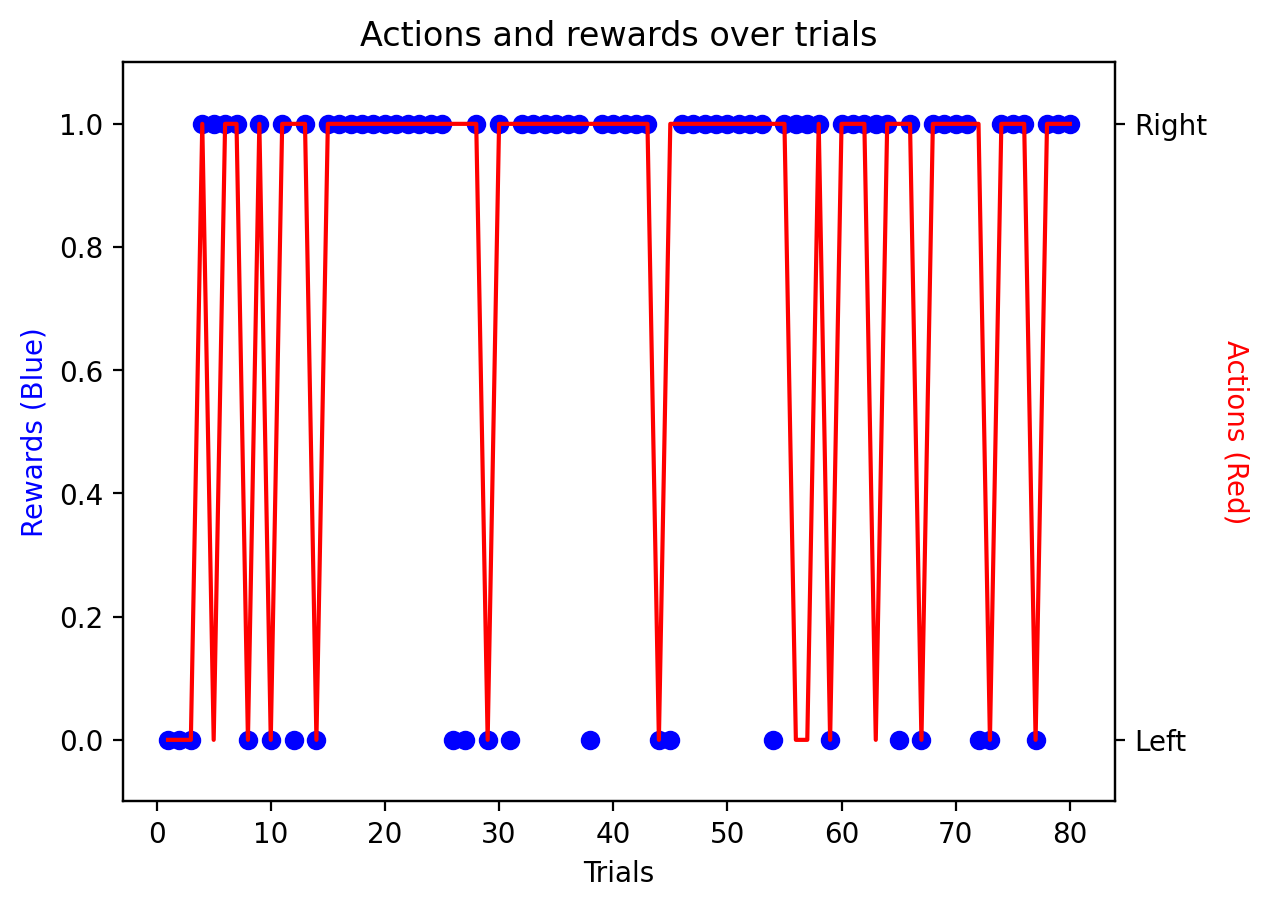

In [16]:
# plot actions and rewards over trials for this agent
fig, ax = plt.subplots()
ax.scatter(sim_output['timestep'], sim_output['rewards'], label='Reward', color='blue')
ax.set_xlabel('Trials')
ax.set_ylabel('Rewards (Blue)', color='blue')
ax.set_ylim(-0.1, 1.1)

ax2 = ax.twinx()
ax2.plot(sim_output['timestep'], [1 if x == 1 else 0 for x in sim_output['actions']], label='Action', color='red')
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Left', 'Right'])
ax2.set_ylabel('Actions (Red)', color='red', rotation=270, labelpad=15)

plt.title('Actions and rewards over trials')
plt.show()

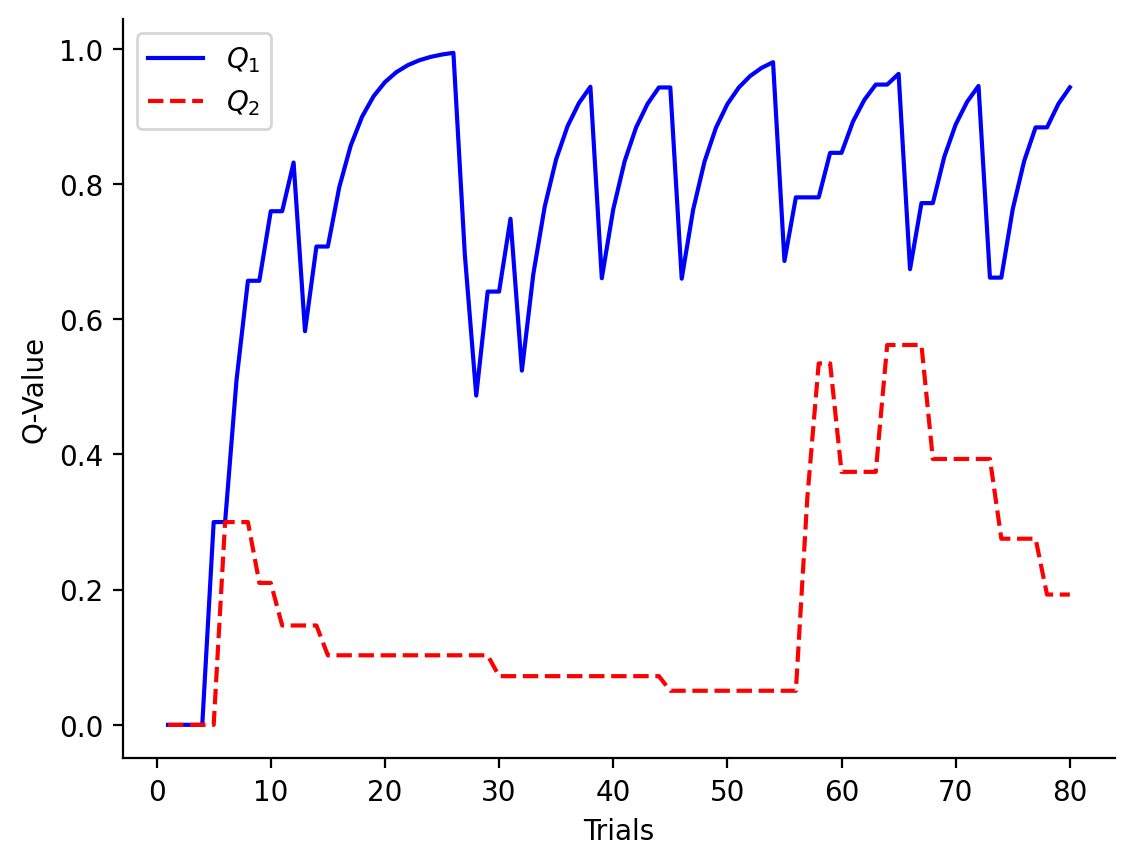

In [17]:
# also plot Q-values over trials
fig, ax = plt.subplots()
ax.plot(sim_output['timestep'], sim_output['q_1'], label=r'$Q_{1}$', color='blue')
ax.plot(sim_output['timestep'], sim_output['q_2'], label=r'$Q_{2}$', color='red', linestyle='--')
ax.set_xlabel('Trials')
ax.set_ylabel('Q-Value')
ax.legend()
sns.despine()
plt.show()

<hr width=50%>

### Estimating Parameters with MLE
Now we can try to accurately estimate the free parameters: $\alpha$, $\beta$, and $\gamma$ that best explain a set of observed state transitions and rewards. Similar to the linear regression example, we will use both **grid search** and **`scipy.optimize.minimize`** to find the parameter values that maximize the likelihood of the observed data.

The likelihood of the observed data depends on both the value updates and the action choices made by the agent. We will use the **negative log-likelihood** as the objective function to minimize.

The negative log-likelihood function for the TD Learning model can be expressed as:

$$
-\log \mathcal{L}(\beta, \alpha, \gamma) = -\sum_{t=1}^{T} \log P(A_t | S_t, \beta, \alpha, \gamma)
$$

where $P(A_t | S_t, \beta, \alpha, \gamma)$ is the probability of selecting action $A_t$ given state $S_t$ and the model parameters $\beta, \alpha, \gamma$.

In [18]:
# define the negative loglikelihood function
def negll_rl(params, actions, rewards):
    """Compute the negative log-likelihood of the TD-learning model.
    
    Parameters
    ----------
    params : list
        List of parameters for the model.
    actions : array
        Array of actions made by the agent.
    rewards : array
        Array of rewards received by the agent.
    
    Returns
    -------
    nll : float
        Negative log-likelihood of the model.
    """
    # extract parameters (set gamma to 0)
    alpha, beta = params
    gamma = 0

    # recode actions: 1 --> 0, 2 --> 1
    actions = np.array(actions) - 1

    # initialize Q-values
    q = np.zeros(2)

    # initialize negative log-likelihood
    nll = 0

    # loop over trials
    for t in range(len(actions)):
        # compute probabilities of each action
        probs = softmax(q, beta)

        # compute negative log-likelihood
        nll -= np.log(probs[actions[t]])

        # update Q-values
        delta = rewards[t] + gamma * max(q) - q[actions[t]]
        q[actions[t]] += alpha * delta

    return nll

In [19]:
# use the TD-learning model to fit the simulated data with a grid search
alpha_grid = np.linspace(0, .5, 50)
beta_grid = np.linspace(.5, 3, 50)
nll = np.zeros((50, 50))

for i in range(50):
    for j in range(50):
            nll[i, j] = negll_rl([alpha_grid[i], beta_grid[j]], sim_output['actions'], sim_output['rewards'])

# find the optimal parameters
i, j = np.unravel_index(nll.argmin(), nll.shape)
alpha_opt = alpha_grid[i]
beta_opt = beta_grid[j]

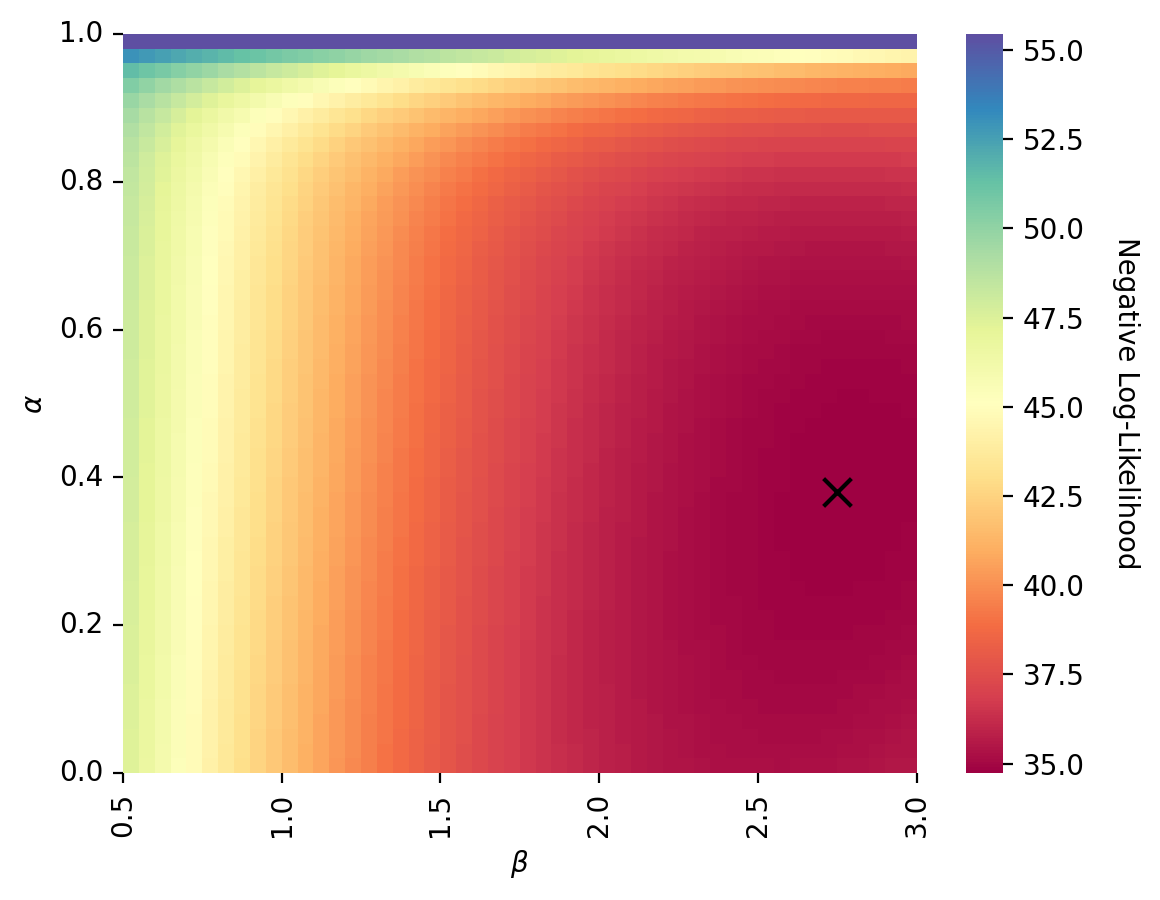

In [20]:
# plot the negative log-likelihood as a heatmap
fig, ax = plt.subplots()
sns.heatmap(nll, ax=ax, cmap='Spectral')

# relabel the ticks
ax.set_ylabel(r'$\alpha$')
ax.set_yticks(np.linspace(50, 0, 6))
ax.set_yticklabels([np.round(x,2) for x in np.linspace(0, 1, 6)])

ax.set_xlabel(r'$\beta$')
ax.set_xticks(np.linspace(0, 50, 6))
ax.set_xticklabels([np.round(x,2) for x in np.linspace(.5, 3, 6)])

# mark the optimal parameters
ax.scatter(j, i, color='black', marker='x', s=100)

ax.collections[0].colorbar.set_label('Negative Log-Likelihood', rotation=270, labelpad=20)

plt.show()

In [21]:
# print the estimated parameters from the grid search
print(f'Parameter | Actual | Estimated')
print(f'alpha     |  {settings["alpha"]}  |  {alpha_opt:.2f}')
print(f'beta      |  {settings["beta"]}   |  {beta_opt:.2f}')

Parameter | Actual | Estimated
alpha     |  0.3  |  0.32
beta      |  2.15   |  2.80


In [22]:
# now let's use scipy to minimize the negative log-likelihood
initial_guess = [.2, 1]
result = scipy.optimize.minimize(negll_rl, initial_guess, args=(sim_output['actions'], sim_output['rewards']), bounds=[(0, 1), (.001, 10)])
alpha_hat, beta_hat = result.x

In [23]:
# print the estimated parameters from the optimization
print(f'Parameter | Actual | Estimated')
print(f'alpha     |  {settings["alpha"]}  |  {alpha_hat:.2f}')
print(f'beta      |  {settings["beta"]}  |  {beta_hat:.2f}')

Parameter | Actual | Estimated
alpha     |  0.3  |  0.31
beta      |  2.15  |  2.81


<hr width=50%>

In [24]:
# we can simulate multiple agents too 
rl_param_names = ['alpha', 'beta']

nsubjects = 100
alphamin, alphamax = .05, .95
betamin, betamax   = .75,  8

rl_params = np.ones((nsubjects, 2))
for simS in range(nsubjects):
    # For alpha, we will sample from a beta distribution and then transform
    rl_params[simS, 0] = scipy.stats.beta.rvs(1.1, 1.1)
    while rl_params[simS, 0] > alphamax or rl_params[simS, 0] < alphamin:
        rl_params[simS, 0] = scipy.stats.beta.rvs(1.1, 1.1)

    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    rl_params[simS, 1] = scipy.stats.gamma.rvs(1, scale=5)
    while rl_params[simS, 1] > betamax or rl_params[simS, 1] < betamin:
        rl_params[simS, 1] = scipy.stats.gamma.rvs(1, scale=5)

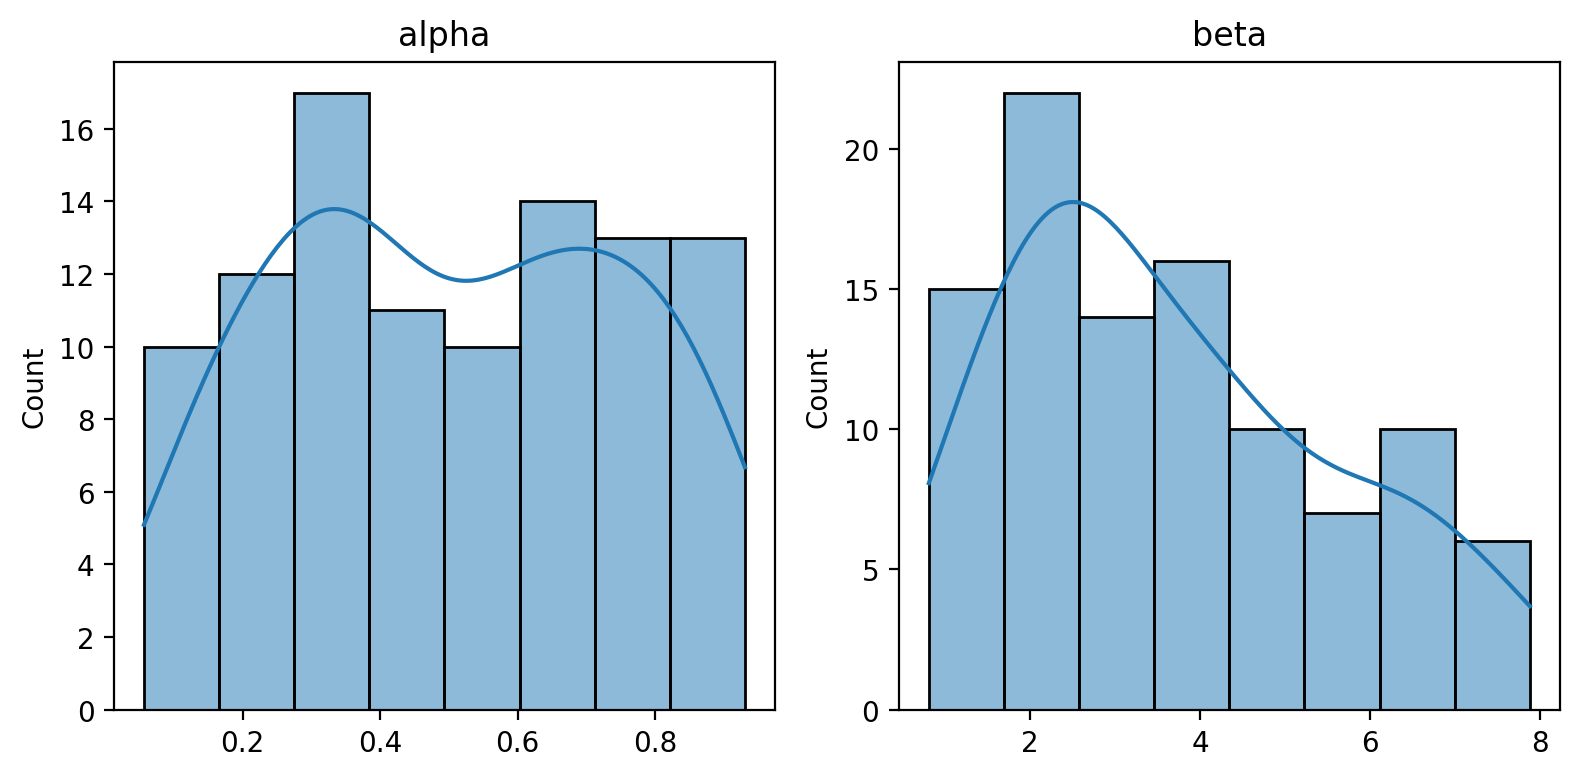

In [25]:
# plot distributions of params
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(len(rl_param_names)):
    sns.histplot(rl_params[:,i], kde=True, ax=ax[i])
    ax[i].set_title(rl_param_names[i])
plt.tight_layout()
plt.show()

In [26]:
# simulate agents
rl_data = []
q_data = []
for simS in range(nsubjects):
    settings = {'n_arms': 2,
              'best_action': 1,
              'p_best': 0.8,
              'p_other': 0.2,
              'alpha': rl_params[simS, 0],
              'beta': rl_params[simS, 1],
              'gamma': 0,
              'q_init': 0}

    sim_env, sim_agent, sim_output = run_simulation(n_timesteps=n_timesteps, params=settings)
    rl_data.append([sim_output['actions'].copy(), sim_output['rewards'].copy()])
    q_data.append([sim_output['q_1'].copy(), sim_output['q_2'].copy()])

In [27]:
# and we can fit a separate model to each agent to estimate their parameters
rl_est_params = np.zeros((nsubjects, 2))
for simS in range(nsubjects):
    # randomize initial guess
    initial_guess = [np.random.uniform(0, 1), np.random.uniform(.001, 5)]

    # fit using scipy
    result = scipy.optimize.minimize(negll_rl, initial_guess, args=(rl_data[simS][0], rl_data[simS][1]), bounds=[(0, 1), (.001, 20)])
    rl_est_params[simS, :] = result.x

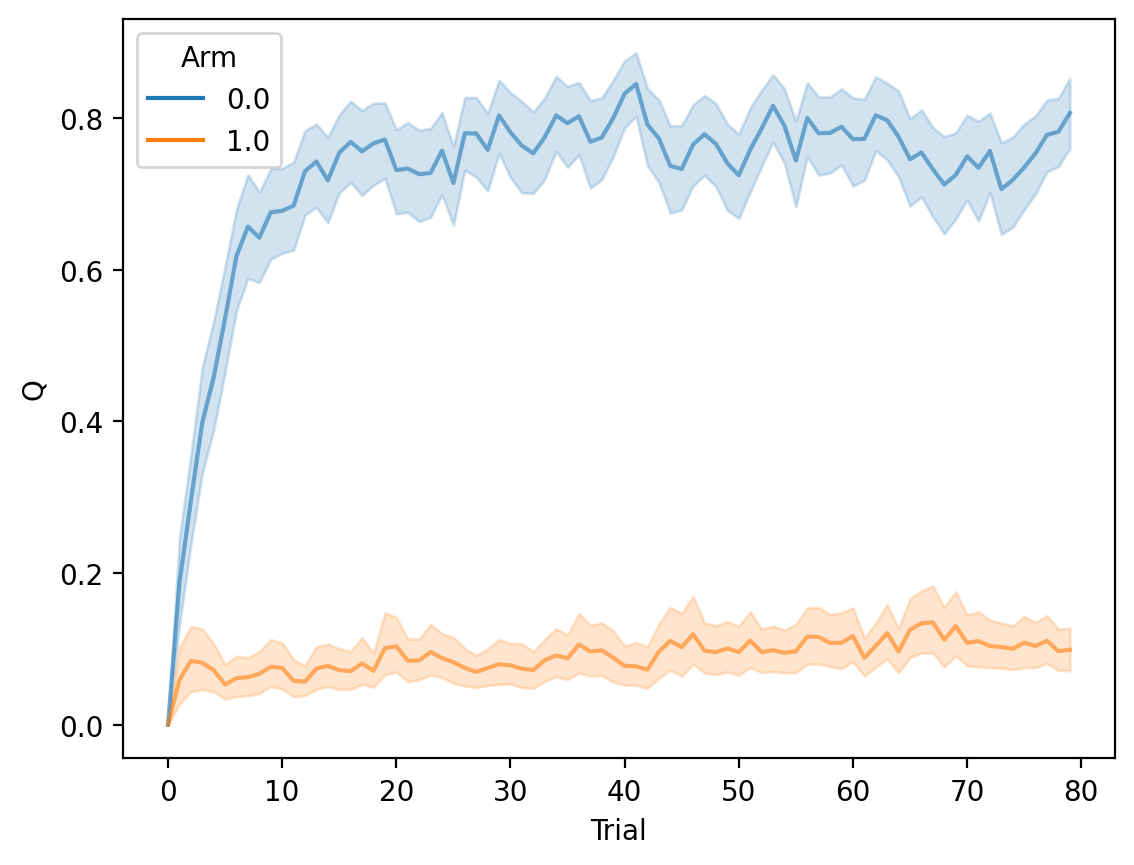

In [28]:
# plot average Q over trials
rew_df = pd.DataFrame()
for simS in range(nsubjects):
    # concat to dataframe
    rew_df = pd.concat([rew_df, pd.DataFrame({'Subject': np.ones(n_timesteps)*simS, 'Trial': np.arange(n_timesteps), 'Q': q_data[simS][0], 'Arm': np.ones(n_timesteps)*0})])
    rew_df = pd.concat([rew_df, pd.DataFrame({'Subject': np.ones(n_timesteps)*simS, 'Trial': np.arange(n_timesteps), 'Q': q_data[simS][1], 'Arm': np.ones(n_timesteps)})])

fig, ax = plt.subplots()
ax = sns.lineplot(data=rew_df, x='Trial', y='Q', hue='Arm', dashes=False, alpha=0.6)
plt.show()

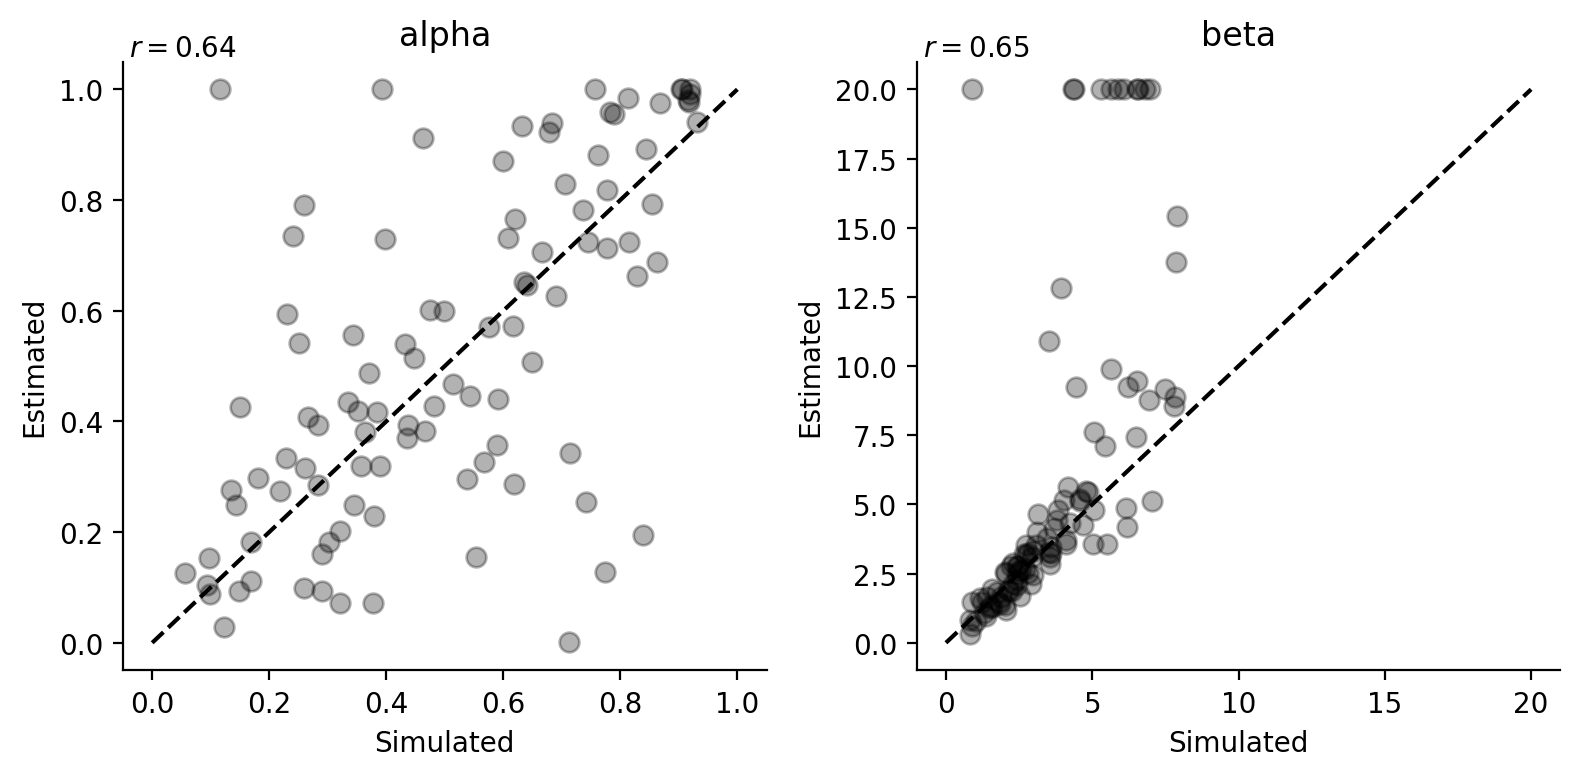

In [29]:
# plot the estimated parameters (y) versus simulated (x)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].scatter(rl_params[:,i], rl_est_params[:,i], color='black', alpha=0.3, s=50)
    ax[i].set_xlabel('Simulated')
    ax[i].set_ylabel('Estimated')
    ax[i].set_title(rl_param_names[i])
    sns.despine()

    # plot y=x line dashed
    if i == 0:
        ax[i].plot([0, 1], [0, 1], 'k--')
    else:
        ax[i].plot([0, 20], [0, 20], 'k--')

    # annotate with Pearson r and p-value
    r, p = scipy.stats.pearsonr(rl_params[:,i], rl_est_params[:,i])
    ax[i].annotate(fr'$r={r:.2f}$', xy=(0.01, 1.01), xycoords='axes fraction')

plt.tight_layout()
plt.show()

We estimated the parameters of the TD Learning model using both a brute force grid search and scipy.optimize.minimize. Both methods failed to perfectly match the true parameters due to data noise and optimization limitations. MLE also performed poorly, highlighting its limitations in capturing the variability of individual agents.

The scipy.optimize.minimize function generally outperformed grid search, as it uses advanced algorithms like BFGS to efficiently navigate the parameter space with gradient information, while grid search is computationally expensive and less precise.

Next, we turn to hierarchical modeling, which can help us better account for individual differences (when fitting models to multiple agents' behavior) and improve parameter estimation.

<hr width=50%>

## Hierarchical Modeling, Maximum A Posteriori (MAP) Estimation, and the Expectation-Maximization (EM) Algorithm

Hierarchical modeling is a powerful technique that allows us to estimate parameters at multiple levels of a model. This approach is particularly useful when we have data from multiple subjects or conditions and want to estimate parameters that vary across these groups.

In the context of MLE, hierarchical modeling can be used to estimate individual-level parameters (e.g., learning rate, inverse temperature) and group-level "hyper" parameters (e.g., their mean, variance) simultaneously. This approach allows us to capture individual differences while also leveraging information across subjects to improve parameter estimation.

### What is Maximum A Posteriori (MAP) Estimation?

Maximum A Posteriori (MAP) estimation is a Bayesian approach that combines prior knowledge about the parameters with the likelihood of the observed data to estimate the parameters. In contrast to MLE, which only considers the likelihood of the data, MAP estimation incorporates prior beliefs about the parameters into the estimation process.

Our likelihood function is the same as in MLE, representing the probability of observing the data given the parameters:

$$
\mathcal{L}(\theta) = P(\mathcal{D} | \theta)
$$

In MAP estimation, we also include a prior distribution over the parameters, denoted as $P(\theta)$, which captures our beliefs about the parameters before observing the data. The goal of MAP estimation is to find the parameter values that maximize the posterior distribution of the parameters given the data:

$$
\theta^* = \text{argmax}_{\theta} \; P(\theta | \mathcal{D}) = \text{argmax}_{\theta} \; P(\mathcal{D} | \theta) \cdot P(\theta)
$$

In [30]:
# let's use the linear modeling example to simulate a ton of data
def simulate_lm(params, ntrials):
    '''
    Simulates a general linear model (e.g., Y ~ b0 + b1*X1 + b2*X2 + ...) with params.shape[1] features
    '''
    nsubjects, nparams = params.shape

    Y_out = np.zeros((nsubjects, ntrials))
    X_out = np.zeros((nsubjects, ntrials, nparams))
    for subj in range(nsubjects):
        # Generate data
        np.random.seed(2021)

        # Random X with intercept
        X_out[subj,:,:] = np.concatenate((np.ones((ntrials, 1)), 
                    np.random.normal(size=(ntrials, nparams-1))), axis=1)

        # Y as function of X + noise
        Y_out[subj,:] = np.dot(X_out[subj,:], params[subj,:]) + np.random.normal(size=(ntrials,))

    return X_out, Y_out

np.random.seed(42)

param_names = ['b0', 'b1', 'b2']
nparams = len(param_names)
nsubjects = 100
ntrials = 100
Y_out = np.zeros((nsubjects, ntrials))
X_out = np.zeros((nsubjects, ntrials, nparams))
params = np.ones((nsubjects, nparams))

all_data = []
for simS in range(nsubjects):
    for parP in range(nparams):
        # we will sample from a normal distribution
        params[simS, parP] = scipy.stats.norm.rvs(0, scale=1)

In [31]:
X_out, Y_out = simulate_lm(params, ntrials)
all_data = [[y,x] for y,x in zip(Y_out, X_out)]

Subject 21; b1=0.81


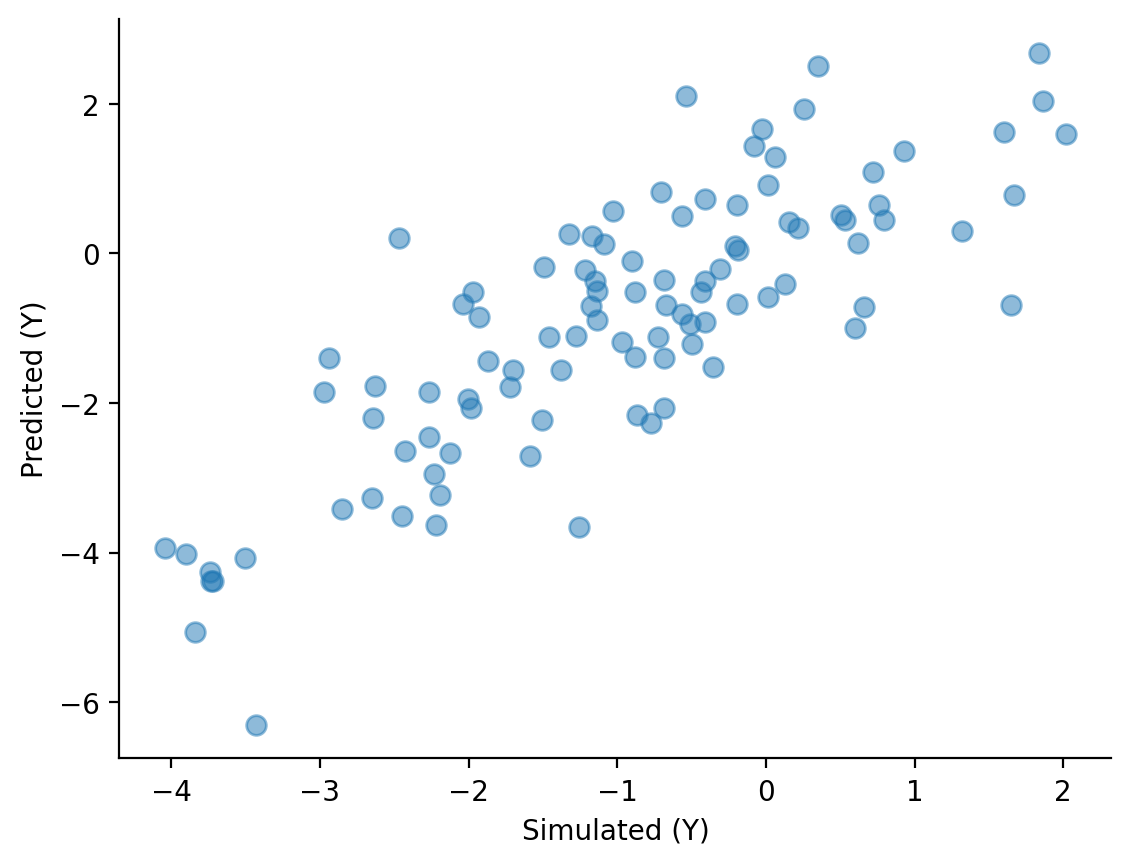

In [32]:
# plot a subject
subject_test = 21
print(f'Subject {subject_test}; b1={params[subject_test,1]:.2f}')
plt.scatter(np.dot(X_out[subject_test,:,:], params[subject_test,:]), 
            Y_out[subject_test], alpha=0.5, s=50)
plt.ylabel('Predicted (Y)')
plt.xlabel('Simulated (Y)')
sns.despine()
plt.show()

In [33]:
# let's amend the negll function to include a prior and setting to specify posterior
def map_lm(params, y, X, prior=None, output='npl'):
    b0, b1, b2 = params

    y_pred = np.dot(X, params) 
    likelihoods = scipy.stats.norm.logpdf(y, y_pred)
    negll = -np.sum(likelihoods)

    if output == 'npl' and prior is not None:
        npl = -(-negll + prior['logpdf'](params))
        return npl
    else:
        return negll

<hr width=50%>

### What is Expectation-Maximization (EM)?

The Expectation-Maximization (EM) algorithm is an iterative optimization method used to estimate model parameters. The EM algorithm consists of two steps:
1. Expectation (E) Step: Estimate the expected value of the latent variables given the observed data and current estimates of the parameters.
2. Maximization (M) Step: Maximize the likelihood function with respect to the parameters, using the expected values computed in the E Step.

The EM algorithm repeats these steps until convergence, effectively finding the parameters that maximize the likelihood of the observed data, even when there are unobserved components.

### Hierarchical Modeling with the EM Algorithm

In the context of hierarchical modeling, the EM algorithm can be used to estimate both individual-level and group-level parameters. The EM algorithm iteratively estimates the individual-level parameters (E Step) and then updates the group-level parameters (M Step) based on the individual-level estimates. This process continues until convergence, providing estimates of both individual and group-level parameters. We can apply the EM algorithm with MAP estimation to fit hierarchical models to behavioral data.

In [34]:
# Pseudo-code for this algorithm:
# 1. Initialize the group-level parameters
# 2. Repeat until convergence:
#   a. E Step: Estimate individual-level parameters given group-level parameters as prior
#   b. M Step: Update group-level parameters based on individual-level estimates (use as new prior)
# 3. Return the estimated individual and group-level parameters

In [35]:
# we can install the pyEM package to do this using `!python -m pip install git+https://github.com/shawnrhoads/pyEM.git`
# or download it and append the path:
sys.path.append('C:/Users/Shawn/Documents/Python/pyEM')

# we can now import the EMfit function
from pyEM.fitting import EMfit
from pyEM import plotting

In [36]:
# fit using the EM algorithm
fit_output = EMfit(all_data, map_lm, param_names, verbose=False)
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = fit_output.values()

# Here fit_output['m'] contains the individual estimated parameters, and fit_output['posterior'] contains the group means and variances

 -- CONVERGED!!!!!


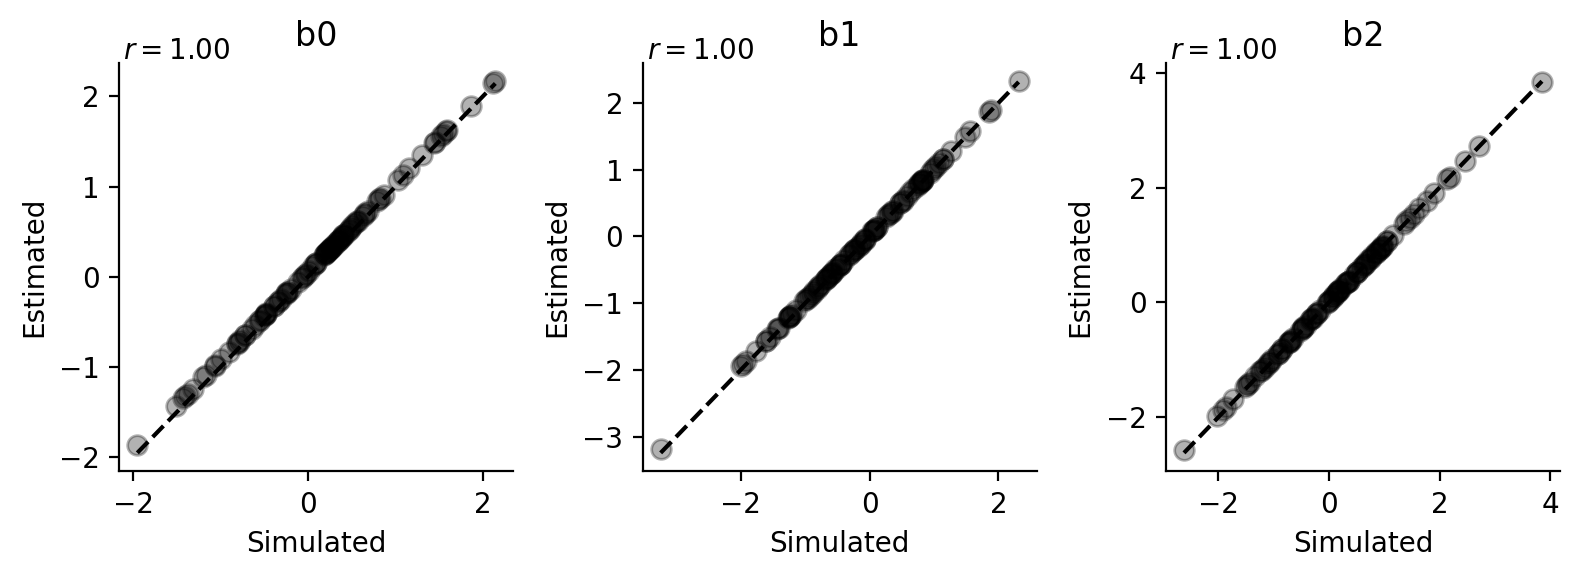

In [37]:
# let's see how well the EM algorithm did
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
for i in range(3):
    ax[i].scatter(params[:,i], fit_output['m'][i,:], color='black', alpha=0.3, s=50)
    ax[i].set_xlabel('Simulated')
    ax[i].set_ylabel('Estimated')
    ax[i].set_title(param_names[i])
    sns.despine()

    # plot y=x line dashed
    ax[i].plot([np.min(params[:,i]), np.max(params[:,i])], [np.min(params[:,i]), np.max(params[:,i])], 'k--')

    # annotate with Pearson r and p-value
    r, p = scipy.stats.pearsonr(params[:,i], fit_output['m'][i,:])
    ax[i].annotate(fr'$r={r:.2f}$', xy=(0.01, 1.01), xycoords='axes fraction')

plt.tight_layout()
plt.show()

This is nearly perfect recovery of the true parameters, demonstrating the power of hierarchical modeling and the EM algorithm in capturing individual differences and improving parameter estimation.

You might also ask if we are overfitting the model... However, the use of hierarchical modeling, particularly with MAP estimation, helps mitigate overfitting by incorporating prior information into the parameter estimation process. The prior acts as a regularizer, preventing the model from fitting noise in the data and ensuring that parameter estimates remain plausible.

We can also quickly check for overfitting by visualizing the predicted versus actual y values. If the model is overfitting, we would expect to see an extremely close match between the predicted and actual values, indicating that the model is capturing noise rather than the underlying structure of the data.

Subject 21; b1=0.81


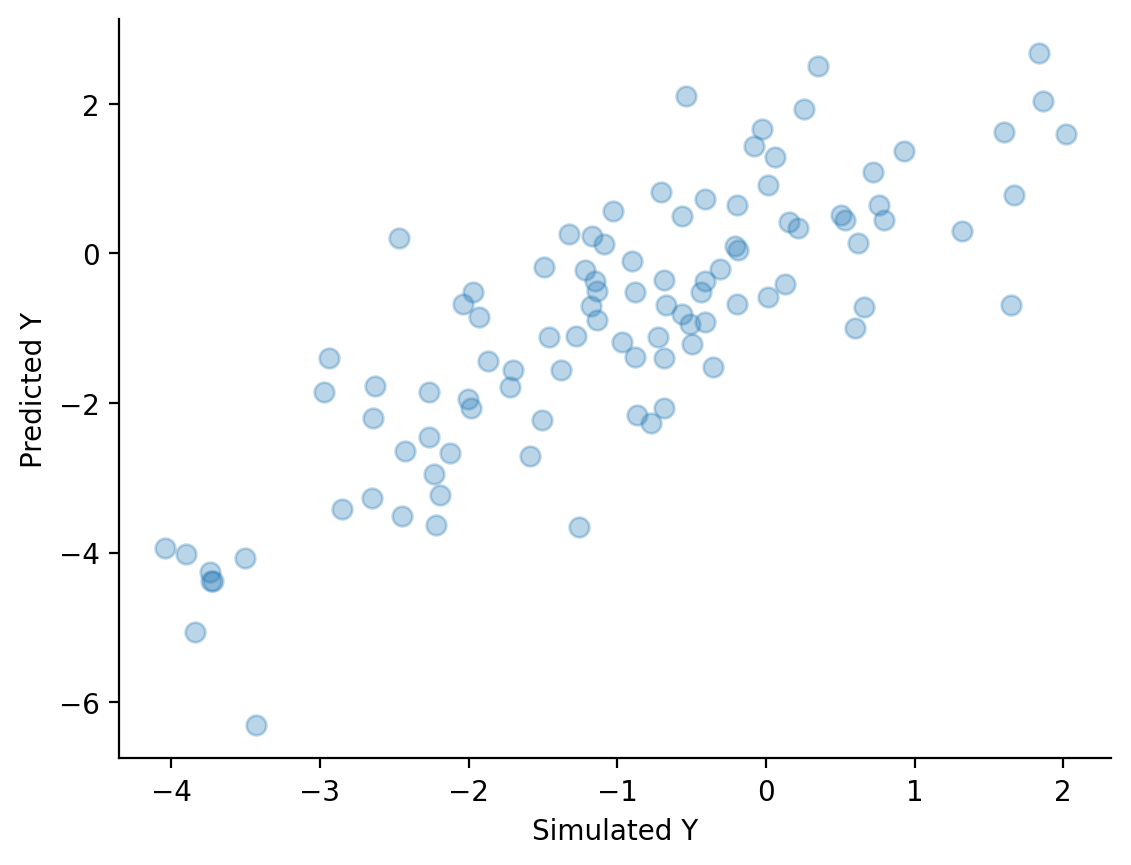

In [38]:
# using the estimated parameters, plot the predicted y values against the true y values for a subject
subject_test = 21
print(f'Subject {subject_test}; b1={params[subject_test,1]:.2f}')
plt.scatter(np.dot(X_out[subject_test,:,:], params[subject_test,:]), 
            Y_out[subject_test], alpha=0.3, s=50)
# plt.scatter(np.dot(X_out[subject_test,:,:], fit_output['m'][:,subject_test]),
#             Y_out[subject_test], alpha=0.5, label='Predicted')
plt.ylabel('Predicted Y')
plt.xlabel('Simulated Y')
sns.despine()
plt.show()

In our case, the plot shows a strong correspondence without excessive variance, which further supports that the model generalizes well to the data. This balance is key to avoiding overfitting while still capturing individual differences in the data.

Overfitting would manifest as either extreme deviations in predictions (if we were over-tuning to the noise in the data) or an overly tight fit to the central trend (if we were under-regularizing). Here, the hierarchical structure and priors prevent both extremes, striking a balance between flexibility and regularization, leading to robust parameter recovery.

<hr width=50%>

You might also notice that this algorithm reflects a mixed-effect linear modeling approach. If so, you would be correct. The individual subject parameters `b0`, `b1`, and `b2` are akin to random effects, while the group-level means (`posterior["mu"]` from `pyEM`) are akin to fixed effects. The EM algorithm effectively combines these two levels of estimation to provide robust parameter estimates that capture both individual differences and group-level trends. 

We can demonstrate this using a standard statistics package like `statsmodels` to fit a mixed-effect linear model to the data.

In [39]:
# use statsmodels to fit mixed effects models with random intercepts and slopes to the same data
# install statsmodels to compare `!python -m pip install statsmodels`
from statsmodels.regression.mixed_linear_model import MixedLM

# create a pandas dataframe
df = pd.DataFrame(columns=['subject', 'x0', 'x1', 'x2', 'Y'])
for subject_idx in range(nsubjects):
    thisX = X_out[subject_idx,:,:]
    thisY = Y_out[subject_idx,:]
    thisdf = pd.DataFrame(np.hstack((np.ones((ntrials,1))*subject_idx, thisX, thisY[:,np.newaxis])),
                          columns=['subject', 'x0', 'x1', 'x2', 'Y'])
    df = pd.concat([df, thisdf])

# fit the model and compare fixed effect to posterior['mu']
model = MixedLM.from_formula('Y ~ 1 + x1 + x2', df, groups='subject')
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y          
No. Observations: 10000   Method:             REML       
No. Groups:       100     Scale:              3.2453     
Min. group size:  100     Log-Likelihood:     -20232.9937
Max. group size:  100     Converged:          Yes        
Mean group size:  100.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.150    0.082  1.832 0.067 -0.011  0.310
x1             -0.151    0.018 -8.571 0.000 -0.185 -0.116
x2              0.099    0.019  5.099 0.000  0.061  0.137
subject Var     0.637    0.053                           



In [40]:
# compare the fixed effects to the posterior means
print(f'Parameter | Estimated | Posterior Means')
print(f'b0        |  {result.params["Intercept"]:.3f}    |  {posterior["mu"][0]:.3f}')
print(f'b1        | {result.params["x1"]:.3f}    | {posterior["mu"][1]:.3f}')
print(f'b2        |  {result.params["x2"]:.3f}    |  {posterior["mu"][2]:.3f}')

Parameter | Estimated | Posterior Means
b0        |  0.150    |  0.150
b1        | -0.151    | -0.151
b2        |  0.099    |  0.099


<hr width=50%>

Now let's consider how to apply MAP estimation and the EM algorithm to fit a reinforcement learning model to data. We will use a hierarchical model to estimate individual-level and group-level parameters, leveraging the EM algorithm to iteratively estimate the parameters.

In [41]:
# define the negative loglikelihood function
from pyEM.math import norm2beta, norm2alpha

def map_rl(params, actions, rewards, prior=None, output='npl'):
    """Compute the negative log-likelihood of the TD-learning model.
    
    Parameters
    ----------
    params : list
        List of parameters for the model.
    actions : array
        Array of actions made by the agent.
    rewards : array
        Array of rewards received by the agent.
    
    Returns
    -------
    nll : float
        Negative log-likelihood of the model.
    """
    # extract parameters
    alpha = norm2alpha(params[0])
    beta = norm2beta(params[1])
    gamma = 0

    # make sure params are in range
    this_alpha_bounds = [0, 1]
    if alpha < min(this_alpha_bounds) or alpha > max(this_alpha_bounds):
        return 10000000
    this_beta_bounds = [0.00001, 20]
    if beta < min(this_beta_bounds) or beta > max(this_beta_bounds):
        return 10000000

    # recode actions: 1 --> 0, 2 --> 1
    actions = np.array(actions) - 1

    # initialize Q-values
    q = np.zeros(2)

    # initialize negative log-likelihood
    nll = 0

    # loop over trials
    for t in range(len(actions)):
        # compute probabilities of each action
        probs = softmax(q, beta)

        # compute negative log-likelihood
        nll -= np.log(probs[actions[t]])

        # update Q-values
        delta = rewards[t] + (gamma * max(q)) - q[actions[t]]
        q[actions[t]] += alpha * delta

    if output == 'npl' and prior is not None:
        npl = -(-nll + prior['logpdf'](params))
        return npl
    else:
        return nll

In [42]:
fit_output_rl = EMfit(rl_data, map_rl, rl_param_names, mstep_maxit=300)

4063.426 (000), 3130.253 (001), 3073.470 (002), 3057.347 (003), 3051.227 (004), 3048.577 (005), 3047.036 (006), 3046.075 (007), 3045.529 (008), 3045.107 (009), 3044.956 (010), 3044.807 (011), 3044.694 (012), 3044.626 (013), 3044.612 (014), 3044.551 (025), 3044.540 (026), 3044.433 (027), 3044.421 (036),  -- CONVERGED!!!!!


In [43]:
# Convert est parameters from Gaussian space back to parameter space
est_rl_params_map = fit_output_rl['m'].T.copy()
for subj_idx in range(fit_output_rl['m'].shape[1]):
    for param_idx, param_name in enumerate(rl_param_names):
        if 'alpha' in param_name:
            est_rl_params_map[subj_idx, param_idx] = norm2alpha(fit_output_rl['m'][param_idx, subj_idx])
        elif 'beta' in param_name:
            est_rl_params_map[subj_idx, param_idx] = norm2beta(fit_output_rl['m'][param_idx, subj_idx])

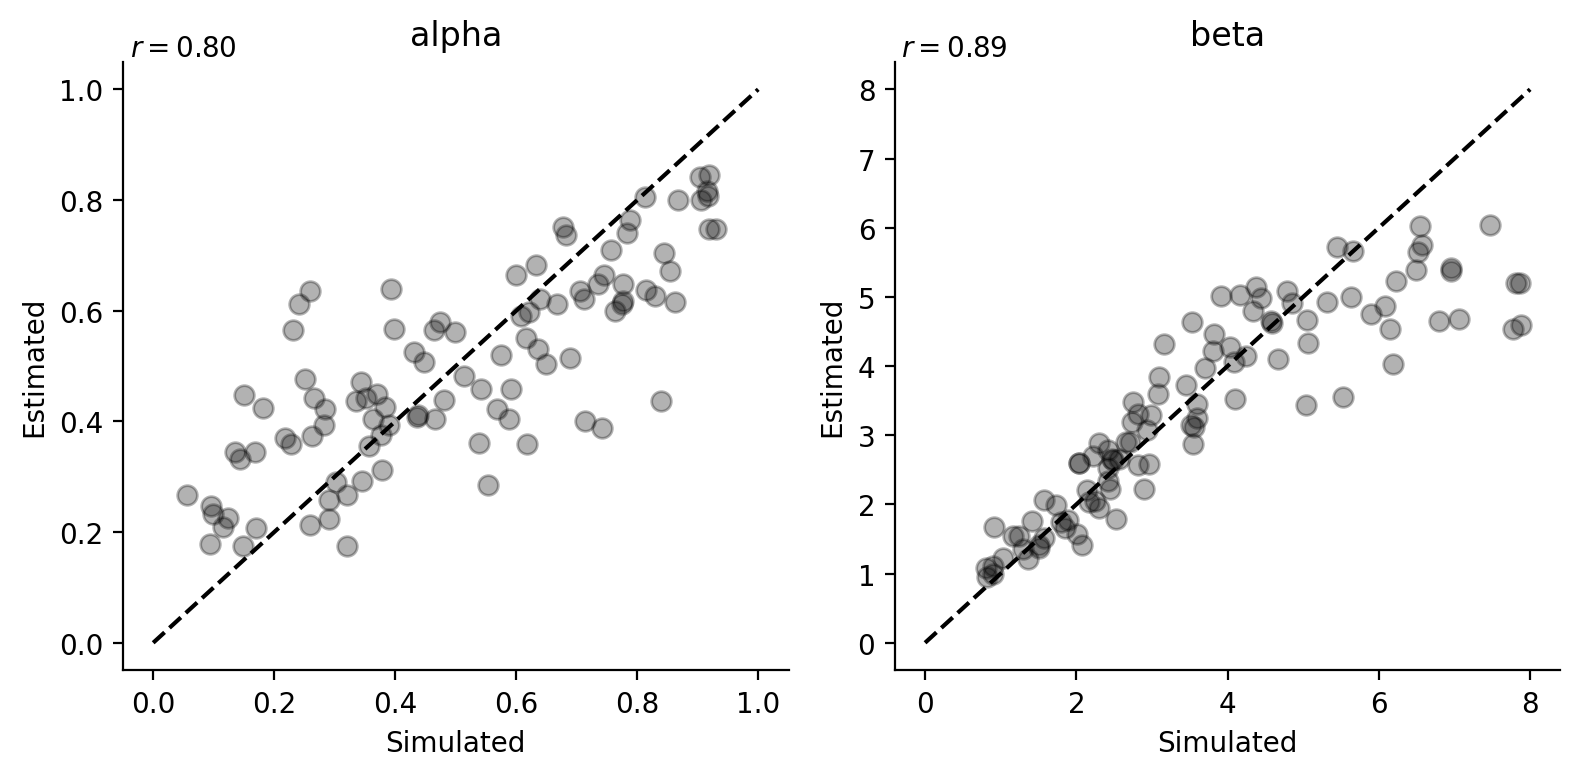

In [46]:
# plot the estimated parameters (y) versus simulated (x)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].scatter(rl_params[:,i], est_rl_params_map[:,i], color='black', alpha=0.3, s=50)
    ax[i].set_xlabel('Simulated')
    ax[i].set_ylabel('Estimated')
    ax[i].set_title(rl_param_names[i])
    sns.despine()

    # plot y=x line dashed
    if i == 0:
        ax[i].plot([0, 1], [0, 1], 'k--')
    else:
        ax[i].plot([0, 8], [0, 8], 'k--')

    # annotate with Pearson r and p-value
    r, p = scipy.stats.pearsonr(rl_params[:,i], est_rl_params_map[:,i])
    ax[i].annotate(fr'$r={r:.2f}$', xy=(0.01, 1.01), xycoords='axes fraction')

plt.tight_layout()
plt.show()

<hr width=50%>

### Summary

In this tutorial, we learned (1) Maximum Likelihood Estimation (MLE) and (2) Hierarchical Maximum A Posteriori (MAP) Estimation with the Expectation-Maximization (EM) algorithm. We applied these methods to fit a linear model and reinforcement learning models to behavioral data, demonstrating how MLE can be used to estimate model parameters and how hierarchical modeling can capture individual differences and improve parameter estimation.


<img src="https://scontent-lga3-2.xx.fbcdn.net/v/t1.6435-9/192874660_277375547403284_6812776080155347208_n.jpg?_nc_cat=104&ccb=1-7&_nc_sid=833d8c&_nc_ohc=s36tGXlN9K0Q7kNvgFjXWxl&_nc_ht=scontent-lga3-2.xx&_nc_gid=Ak4lXPQCYscPZaeBhCFR9rS&oh=00_AYCJkIg9XMtjRHATQQz0Mp_nxxHSzDsGzvD9KdOwYV-rDQ&oe=673E4A9B" alt="meme-all-models-are-wrong" style="width: 25%;">
